# ERROR ANALYSIS

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from datasets.prediction import load
from models.metrics import metrics_regression
import warnings
warnings.filterwarnings('ignore')

### data

In [2]:
# load
data, col = load()
# preparation
data['hour'] = [i.hour for i in data.index.tolist()]
data['month'] = [i.month for i in data.index.tolist()]

Load data..


### arguments 

In [3]:
sobservation = 'y'
sprediction = 'y_hat'
lvar_ref = ['hour', 'month']
nfolks = 15
nX = 8 # None
sfilter = ''

# TOOLS

In [4]:
# validation
for scol in [sobservation, sprediction] + lvar_ref:
    assert scol in data.columns, '"%s" is not available in the data.'%scol
# filter data
try:
    if len(sfilter)>0: 
        data = data.query(sfilter)
except:
    print('[error] it was not filter the data.')
# sort data
data.sort_index(inplace = True)

## PLOT 1: Total Metrics

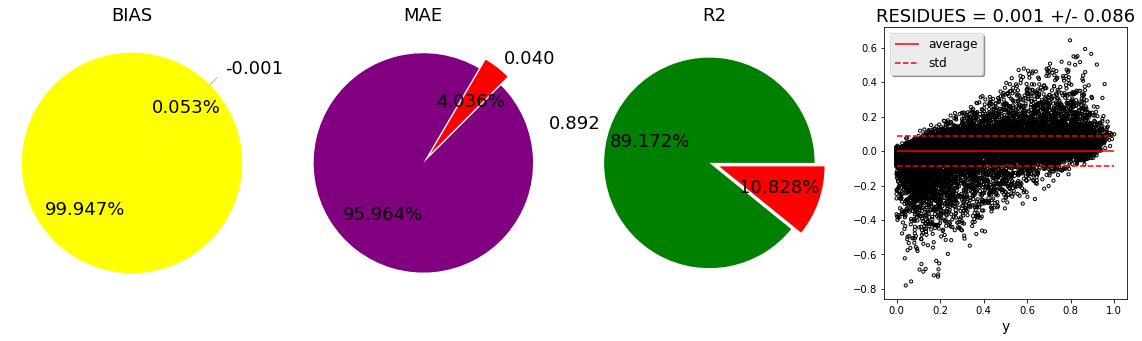

In [5]:
# calculate total metrics
dmetrics = metrics_regression(data[sobservation].values, data[sprediction].values, k = nX)
bias, mae, r2 = dmetrics['bias'], dmetrics['mae'], dmetrics['r2']
# calculate residues
residues = data[sobservation].values - data[sprediction].values
res_avg, res_std = np.mean(residues), np.std(residues) 

## PLOT 1
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(20,5))
# pie1: BIAS
ax1 = plt.subplot2grid((1,4),(0,0))
labels = '%.3f'%bias, ''
sizes = [np.abs(bias)*100./np.max(data[sobservation].values), 
         (np.max(data[sobservation].values) - np.abs(bias))*100. / np.max(data[sobservation].values)]
explode = (0.1, 0)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.3f%%',shadow=False, startangle=45, 
        textprops=dict(fontsize=18), colors  = ['red', 'yellow'])
ax1.axis('equal')
ax1.set_title("BIAS", fontsize = 18)

# pie2: MAE
ax2 = plt.subplot2grid((1,4),(0,1))
labels = '%.3f'%mae, ''
sizes = [np.abs(mae)*100./np.max(data[sobservation].values), 
         (np.max(data[sobservation].values) - np.abs(mae))*100. / np.max(data[sobservation].values)]
explode = (0.1, 0)
ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.3f%%',shadow=False, startangle=45, 
        textprops=dict(fontsize=18), colors  = ['red', 'purple'])
ax2.axis('equal')
ax2.set_title("MAE", fontsize = 18)

# pie3: R2
ax3 = plt.subplot2grid((1,4),(0,2))
labels = '%.3f'%r2, ''
sizes = [np.abs(r2)*100, (1 - np.abs(r2))*100.]
explode = (0.1, 0)
ax3.pie(sizes, explode=explode, labels=labels, autopct='%1.3f%%',shadow=False, startangle=0, 
        textprops=dict(fontsize=18), colors  = ['green', 'red'])
ax3.axis('equal')
ax3.set_title("R2", fontsize = 18)

# histogram: RESIDUES
ax4 = plt.subplot2grid((1,4),(0,3))
bins = np.linspace(min(residues), max(residues), 50)
ax4.scatter(data[sobservation].values,residues, s=10, facecolors='none', edgecolors='black')
ax4.hlines(res_avg, 
           np.min(data[sobservation].values), np.max(data[sobservation].values), 
           colors='red', linestyles='solid', label='average')
ax4.hlines(res_avg + res_std, 
           np.min(data[sobservation].values), np.max(data[sobservation].values), 
           colors='red', linestyles='--', label='std')
ax4.hlines(res_avg - res_std, 
           np.min(data[sobservation].values), np.max(data[sobservation].values), 
           colors='red', linestyles='--')
ax4.legend(loc='best',fontsize=12,shadow=True)
ax4.set_title("RESIDUES = %.3f +/- %.3f"%(res_avg, res_std), fontsize = 18)
ax4.set_xlabel(sobservation, fontsize = 14)
ax4.set_ylabel('')
ax4.set_facecolor('xkcd:white')

# display
plt.subplots_adjust(hspace = 0.6)
plt.show()

# PLOT 2: Trends

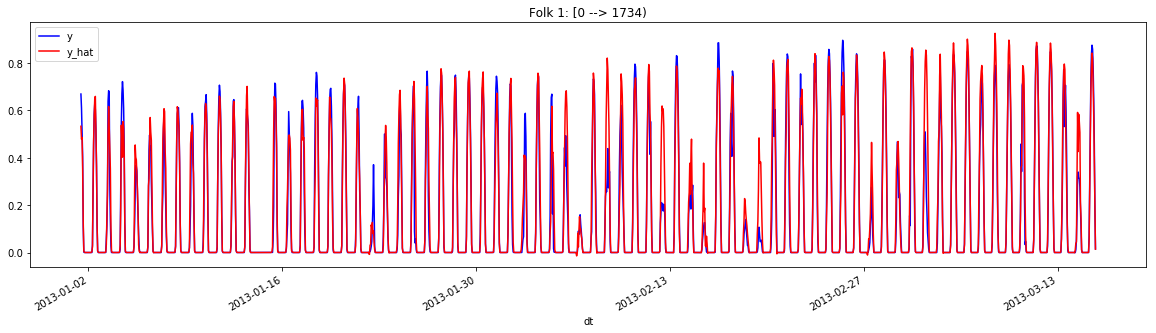

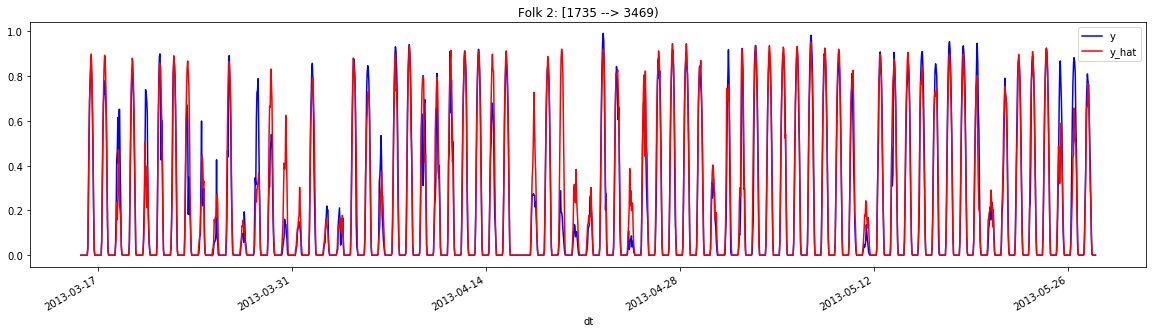

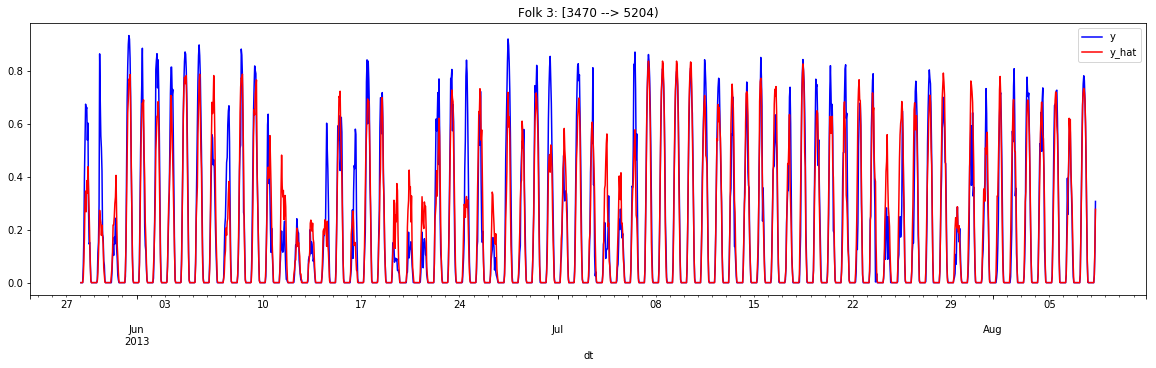

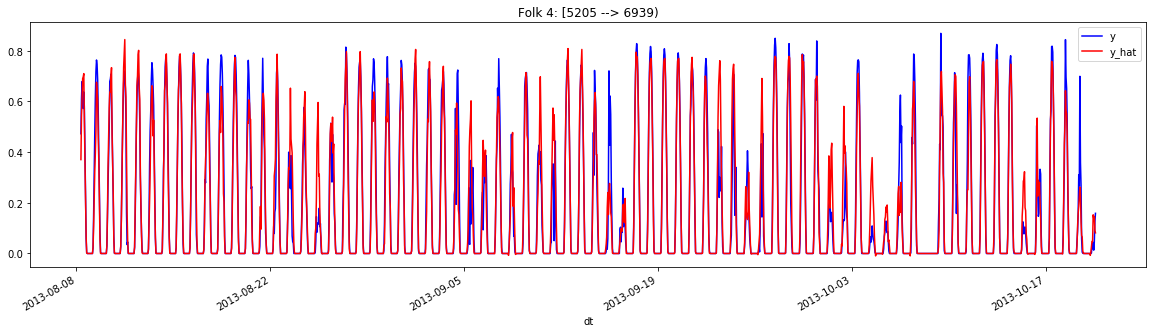

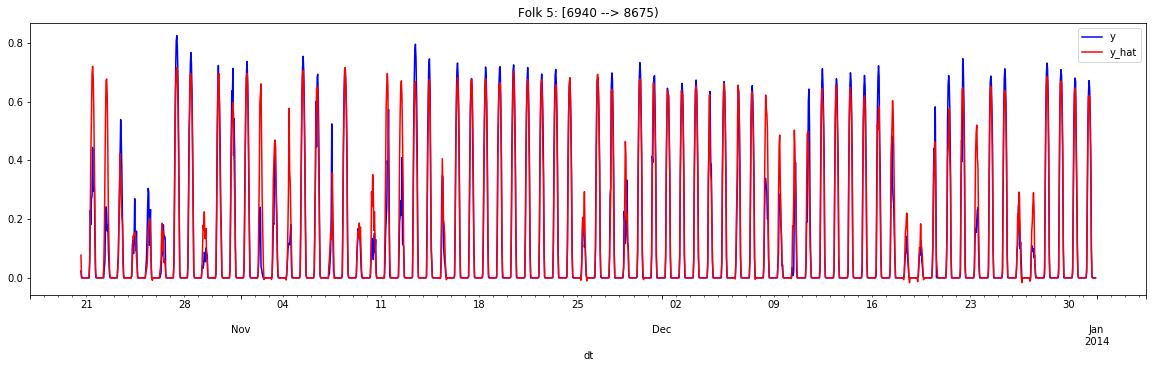

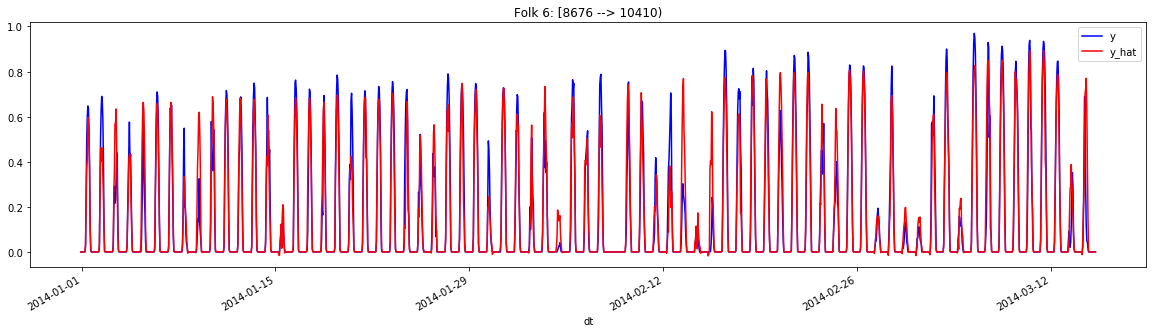

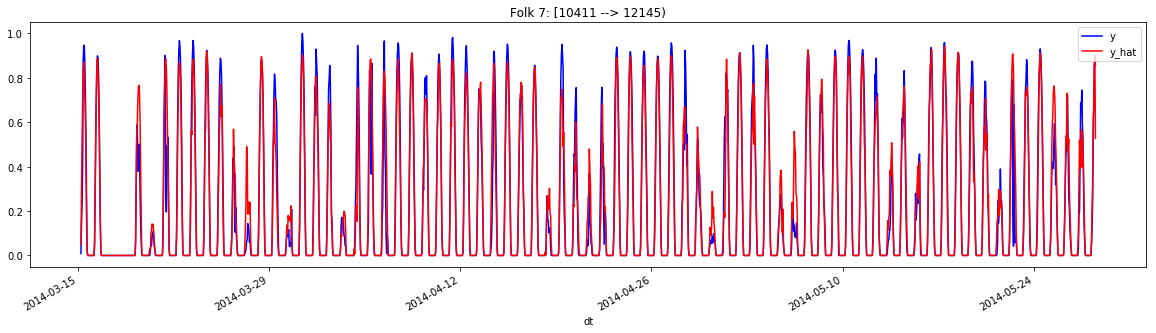

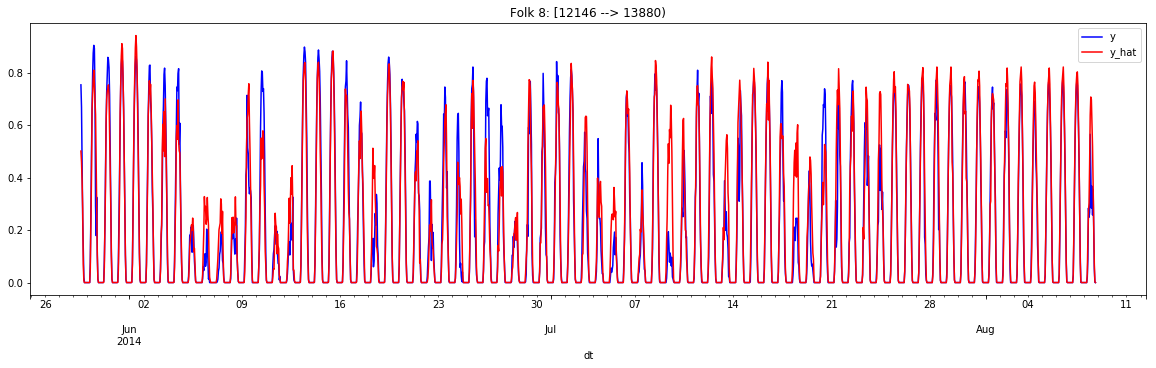

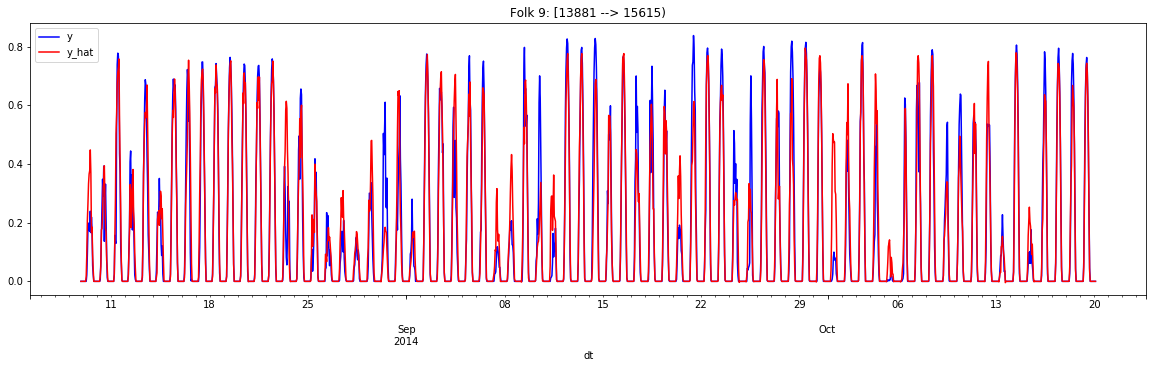

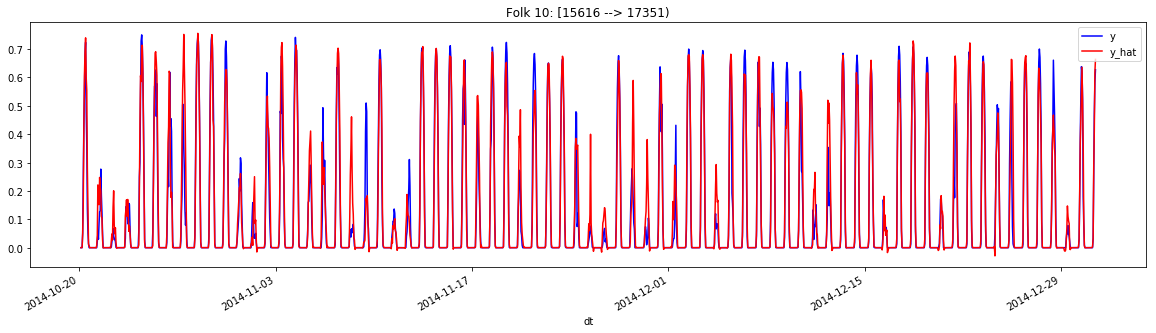

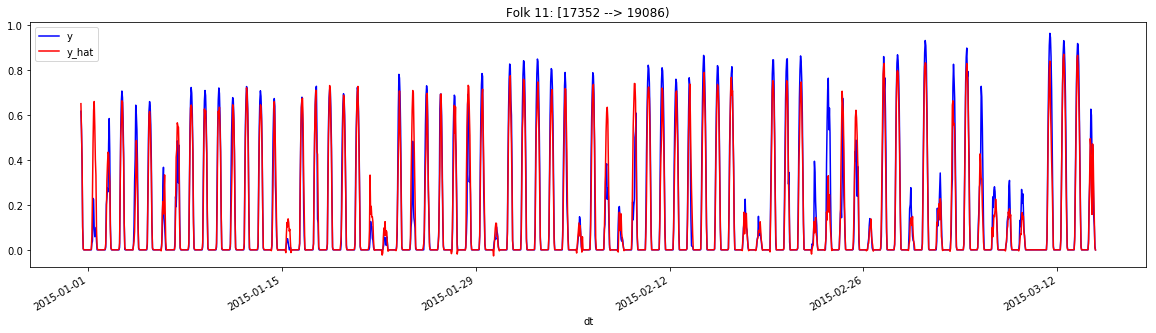

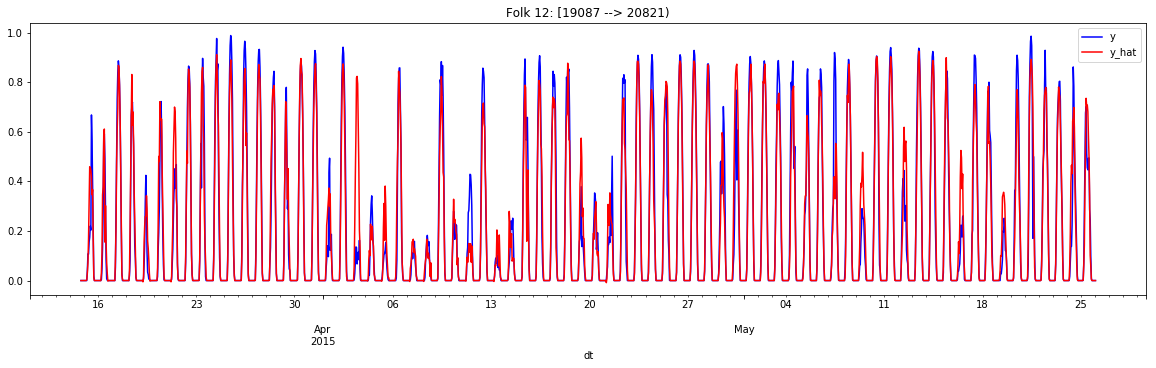

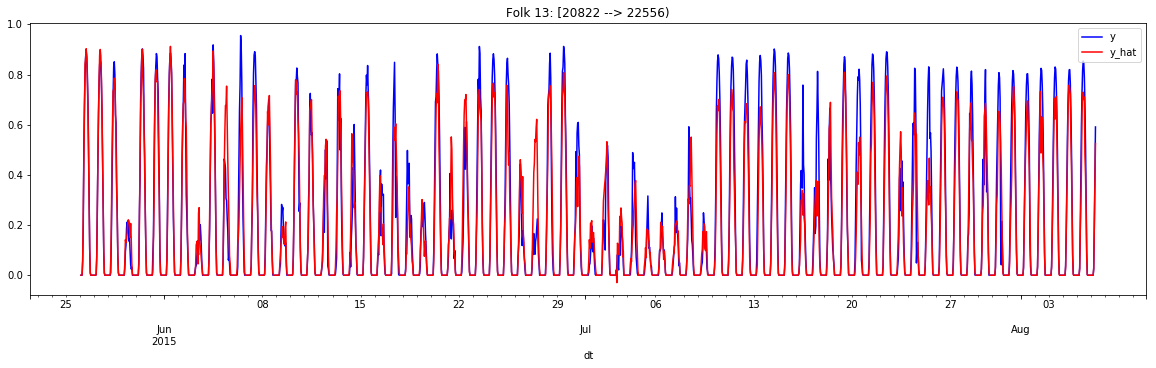

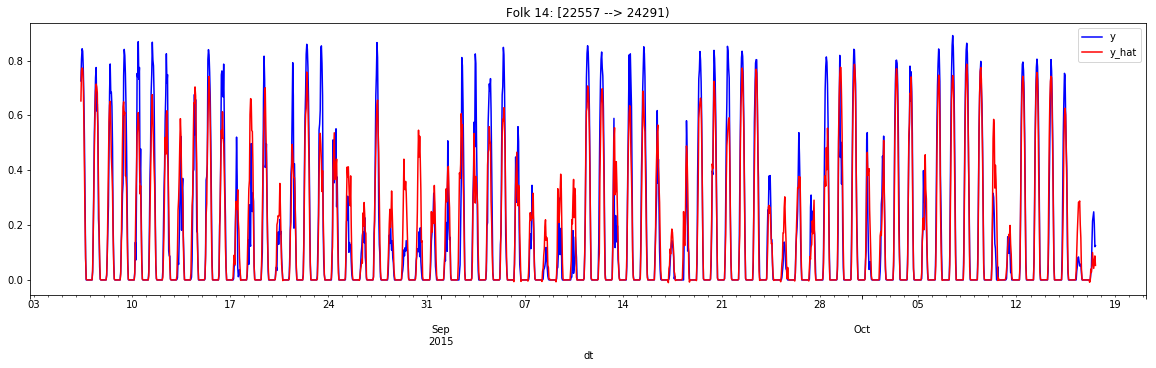

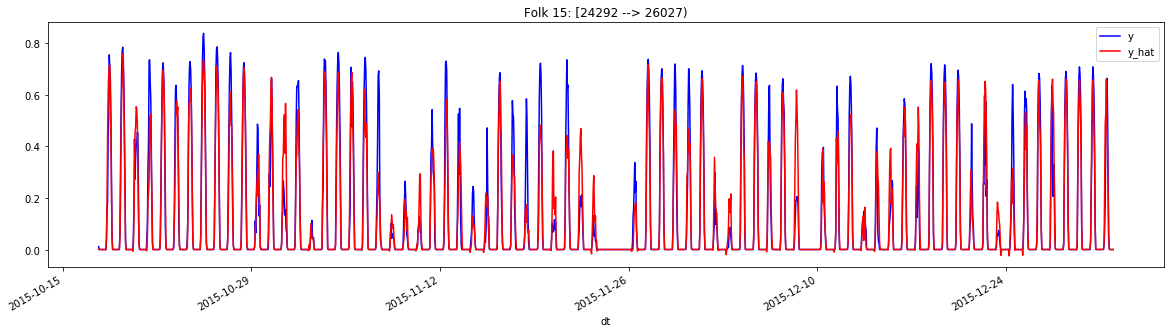

In [67]:
# trend 1: Total
import matplotlib.pyplot as plt
chunks = np.linspace(0, len(data), nfolks+1, dtype = int)
for ii in range(len(chunks)-1):
    stitle = 'Folk %s: [%s --> %s)'%(ii+1 ,chunks[ii], chunks[ii+1]-1)
    ax = data[[sobservation, sprediction]][chunks[ii]:chunks[ii+1]].plot(figsize = (20,5),title = stitle, color = ['blue', 'red'])
    ax.set_facecolor('xkcd:white')
# display
plt.show()

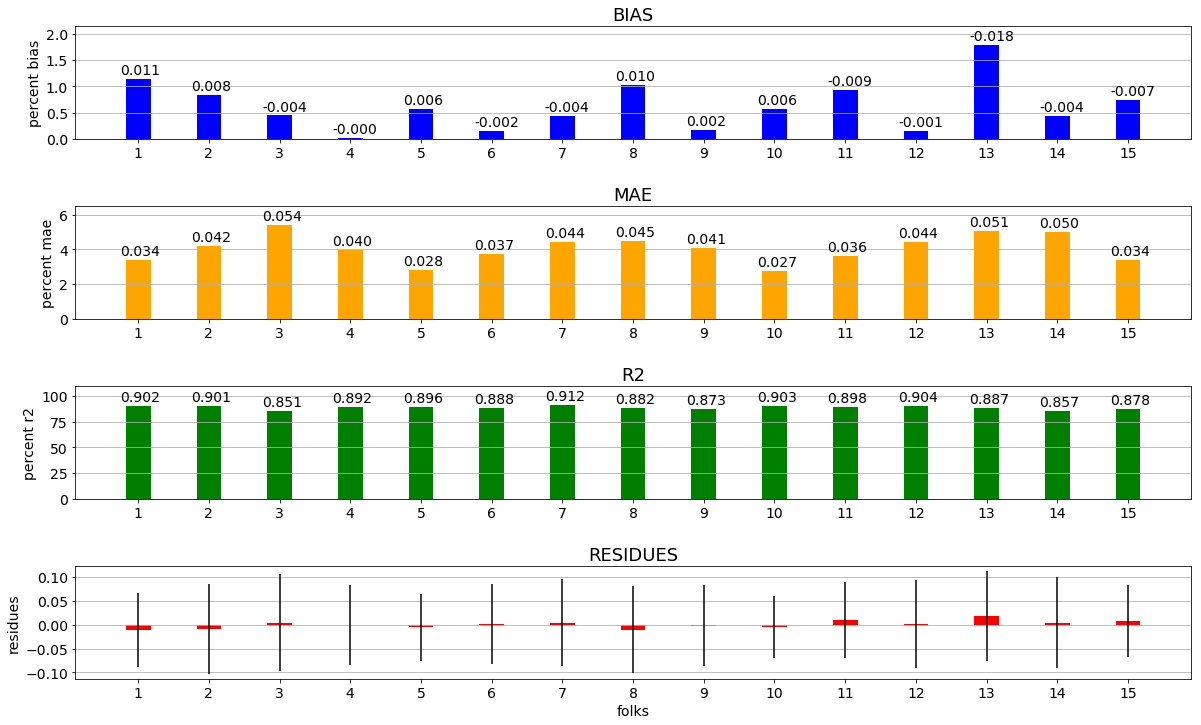

In [111]:
# trend 2: by Folks
chunks = np.linspace(0, len(data), nfolks+1, dtype = int)
lbias = list()
lmae = list()
lr2 = list()
lres_avg = list()
lres_std = list()
lfolk = list()
for ii in range(len(chunks)-1):
    # collect data
    idata = data.iloc[chunks[ii]:chunks[ii+1]]
    # calculate metrics
    dmetrics = metrics_regression(idata[sobservation].values, idata[sprediction].values, k = nX)
    ibias, imae, ir2 = dmetrics['bias'], dmetrics['mae'], dmetrics['r2']
    # calculate residues
    iresidues = idata[sobservation].values - idata[sprediction].values
    ires_avg, ires_std = np.mean(iresidues), np.std(iresidues) 
    # store
    lfolk.append(ii+1)
    lbias.append(ibias)
    lmae.append(imae)
    lr2.append(ir2)
    lres_avg.append(ires_avg)
    lres_std.append(ires_std)
resfolk = pd.DataFrame({
    'folk': lfolk,
    'bias': lbias,
    'mae': lmae,
    'r2': lr2,
    'res_avg': lres_avg,
    'res_std': lres_std
}).set_index('folk')

# calculate percentages
resfolk['pbias'] = resfolk['bias'].apply(lambda x: np.abs(x)*100./np.max(data[sobservation].values))
resfolk['pmae'] = resfolk['mae'].apply(lambda x: np.abs(x)*100./np.max(data[sobservation].values))
resfolk['pr2'] = resfolk['r2'].apply(lambda x: np.abs(x)*100.)

## PLOT PER FOLKS
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(20,12))

# bar: BIAS
ax1 = plt.subplot2grid((4,1),(0,0))
width = 0.35 
p1 = plt.bar(resfolk.index.tolist(), resfolk.pbias.values, width, color = 'blue')
ax1.set_title('BIAS', fontsize = 18)
ax1.set_ylim([0,np.max(resfolk.pbias.values)*1.2])
for i, (v, vp) in enumerate(zip(resfolk.bias.values, resfolk.pbias.values)):
    ax1.annotate('%.3f'%v, (i+1-0.25,vp+0.05*np.max(resfolk.pbias.values)), fontsize = 14 , rotation=0)
ax1.set_ylabel("percent bias", fontsize = 14)
ax1.set_xticks(resfolk.index.tolist())
ax1.set_xticklabels(resfolk.index.tolist(), fontsize=14)
plt.yticks(fontsize=14)
ax1.yaxis.grid(True)

# bar: MAE
ax2 = plt.subplot2grid((4,1),(1,0))
width = 0.35 
p1 = plt.bar(resfolk.index.tolist(), resfolk.pmae.values, width, color = 'orange')
ax2.set_title('MAE', fontsize = 18)
ax2.set_ylim([0,np.max(resfolk.pmae.values)*1.2])
for i, (v, vp) in enumerate(zip(resfolk.mae.values, resfolk.pmae.values)):
    ax2.annotate('%.3f'%v, (i+1-0.25,vp+0.05*np.max(resfolk.pmae.values)), fontsize = 14 , rotation=0)
ax2.set_ylabel("percent mae", fontsize = 14)
ax2.set_xticks(resfolk.index.tolist())
ax2.set_xticklabels(resfolk.index.tolist(), fontsize=14)
plt.yticks(fontsize=14)
ax2.yaxis.grid(True)

# bar: R2
ax3 = plt.subplot2grid((4,1),(2,0))
width = 0.35 
p1 = plt.bar(resfolk.index.tolist(), resfolk.pr2.values, width, color = 'green')
ax3.set_title('R2', fontsize = 18)
ax3.set_ylim([0,np.max(resfolk.pr2.values)*1.2])
for i, (v, vp) in enumerate(zip(resfolk.r2.values, resfolk.pr2.values)):
    ax3.annotate('%.3f'%v, (i+1-0.25,vp+0.05*np.max(resfolk.pr2.values)), fontsize = 14 , rotation=0)
ax3.set_ylabel("percent r2", fontsize = 14)
ax3.set_xticks(resfolk.index.tolist())
ax3.set_xticklabels(resfolk.index.tolist(), fontsize=14)
plt.yticks(fontsize=14)
ax3.yaxis.grid(True)

# bar: RESIDUES
ax4 = plt.subplot2grid((4,1),(3,0))
width = 0.35 
p1 = plt.bar(resfolk.index.tolist(), resfolk.res_avg.values, width, color = 'red', yerr=resfolk.res_std.values)
ax4.set_title('RESIDUES', fontsize = 18)
ax4.set_xlabel("folks", fontsize = 14)
ax4.set_ylabel("residues", fontsize = 14)
ax4.set_xticks(resfolk.index.tolist())
ax4.set_xticklabels(resfolk.index.tolist(), fontsize=14)
plt.yticks(fontsize=14)
ax4.yaxis.grid(True)


# display
plt.subplots_adjust(hspace = 0.6)
plt.show()

## PLOT 3:

In [165]:
# loop of reference variables
#for svar in lvar_ref:
svar = lvar_ref[0]
lvar_values = sorted(data[svar].unique())
# by values of reference variable
chunks = np.linspace(0, len(data), nfolks+1, dtype = int)
lbias = list()
lmae = list()
lr2 = list()
lres_avg = list()
lres_std = list()
lfolk = list()
for ivar_value in lvar_values:
    # collect data
    idata = data[data[svar]==ivar_value]
    # calculate metrics
    dmetrics = metrics_regression(idata[sobservation].values, idata[sprediction].values, k = nX)
    ibias, imae, ir2 = dmetrics['bias'], dmetrics['mae'], dmetrics['r2']
    # calculate residues
    iresidues = idata[sobservation].values - idata[sprediction].values
    ires_avg, ires_std = np.mean(iresidues), np.std(iresidues) 
    # store
    lfolk.append(ivar_value)
    lbias.append(ibias)
    lmae.append(imae)
    lr2.append(ir2)
    lres_avg.append(ires_avg)
    lres_std.append(ires_std)
resfolk = pd.DataFrame({
    svar: lfolk,
    'bias': lbias,
    'mae': lmae,
    'r2': lr2,
    'res_avg': lres_avg,
    'res_std': lres_std
}).set_index(svar)
# drop inf values
resfolk = resfolk.replace([np.inf, -np.inf], np.nan)

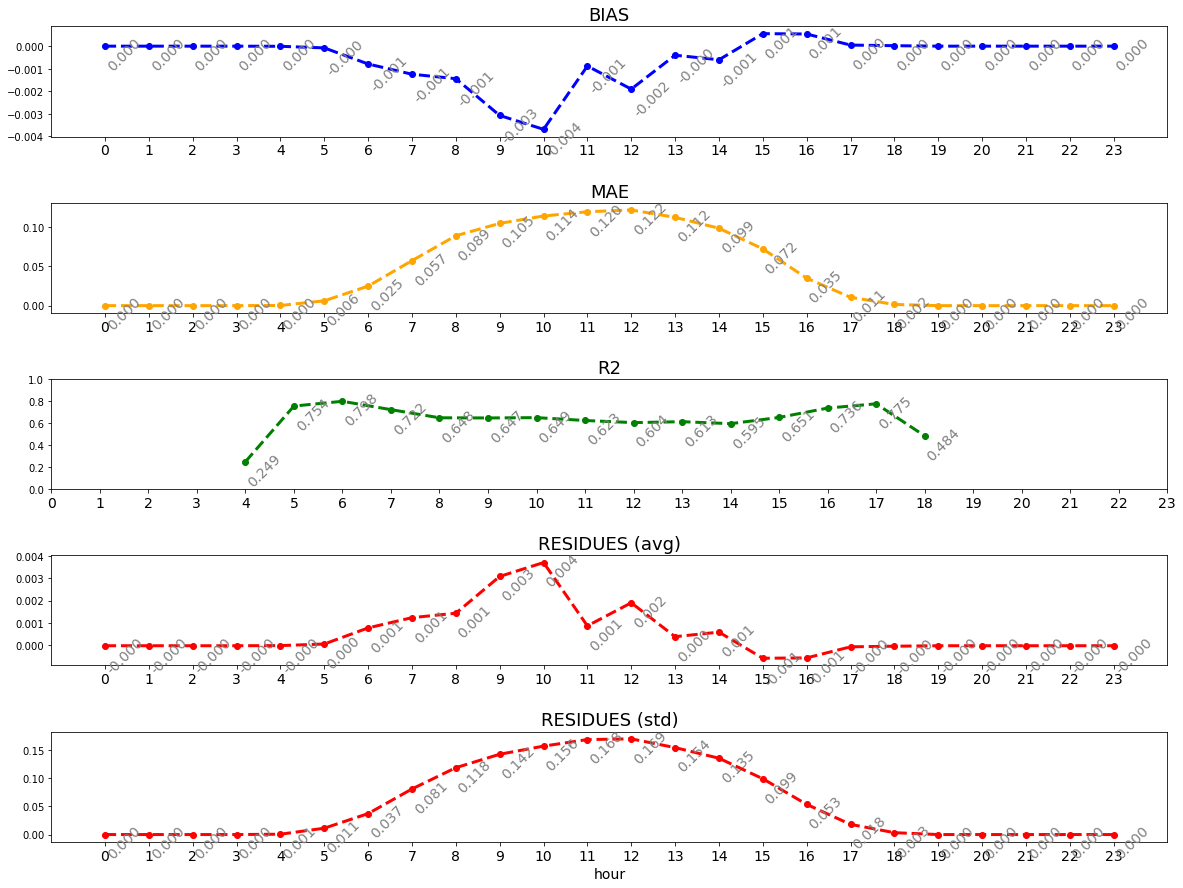

In [172]:
## PLOT PER REFERENCE VARIABLE
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(20,15))

# line: BIAS
ax1 = plt.subplot2grid((5,1),(0,0))
ax1.plot(resfolk.index.tolist(), resfolk.bias.tolist(), linestyle='--', color='blue', linewidth=3)
ax1.scatter(resfolk.index.tolist(), resfolk.bias.tolist(), color = 'blue')
for i, v in enumerate(resfolk.bias.values):
    ax1.annotate('%.3f'%v, (i,v), fontsize = 14 , rotation=45, color = 'grey')
ax1.set_title('BIAS', fontsize = 18)
ax1.set_xticks(resfolk.index.tolist())
ax1.set_xticklabels(resfolk.index.tolist(), fontsize=14)

# line: MAE
ax2 = plt.subplot2grid((5,1),(1,0))
ax2.plot(resfolk.index.tolist(), resfolk.mae.tolist(), linestyle='--', color='orange', linewidth=3)
ax2.scatter(resfolk.index.tolist(), resfolk.mae.tolist(), color = 'orange')
for i, v in enumerate(resfolk.mae.values):
    ax2.annotate('%.3f'%v, (i,v), fontsize = 14 , rotation=45, color = 'grey')
ax2.set_title('MAE', fontsize = 18)
ax2.set_xticks(resfolk.index.tolist())
ax2.set_xticklabels(resfolk.index.tolist(), fontsize=14)

# line: R2
ax3 = plt.subplot2grid((5,1),(2,0))
ax3.plot(resfolk.index.tolist(), resfolk.r2.tolist(), linestyle='--', color='green', linewidth=3)
ax3.scatter(resfolk.index.tolist(), resfolk.r2.tolist(), color = 'green')
for i, v in enumerate(resfolk.r2.values):
    ax3.annotate('%.3f'%v, (i,v), fontsize = 14 , rotation=45, color = 'grey')
ax3.set_title('R2', fontsize = 18)
ax3.set_xticks(resfolk.index.tolist())
ax3.set_xticklabels(resfolk.index.tolist(), fontsize=14)
ax3.set_ylim([0,1])

# line: RESIDUES(avg)
ax4 = plt.subplot2grid((5,1),(3,0))
ax4.plot(resfolk.index.tolist(), resfolk.res_avg.tolist(), linestyle='--', color='red', linewidth=3)
ax4.scatter(resfolk.index.tolist(), resfolk.res_avg.tolist(), color = 'red')
for i, v in enumerate(resfolk.res_avg.values):
    ax4.annotate('%.3f'%v, (i,v), fontsize = 14 , rotation=45, color = 'grey')
ax4.set_title('RESIDUES (avg)', fontsize = 18)
ax4.set_xticks(resfolk.index.tolist())
ax4.set_xticklabels(resfolk.index.tolist(), fontsize=14)

# line: RESIDUES(std)
ax5 = plt.subplot2grid((5,1),(4,0))
ax5.plot(resfolk.index.tolist(), resfolk.res_std.tolist(), linestyle='--', color='red', linewidth=3)
ax5.scatter(resfolk.index.tolist(), resfolk.res_std.tolist(), color = 'red')
for i, v in enumerate(resfolk.res_std.values):
    ax5.annotate('%.3f'%v, (i,v), fontsize = 14 , rotation=45, color = 'grey')
ax5.set_title('RESIDUES (std)', fontsize = 18)
ax5.set_xlabel(svar, fontsize = 14)
ax5.set_xticks(resfolk.index.tolist())
ax5.set_xticklabels(resfolk.index.tolist(), fontsize=14)

# display
plt.subplots_adjust(hspace = 0.6)
plt.show()